In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')


In [61]:


class AnalyseDefectsAll:
    def __init__(self, system_size_list, ):
        self.LX = system_size_list
        self.inputs_paths = [f"data\\nematic_analysis{LX}_LL0.05\\merged_results" for LX in self.LX]
        self.act_list = [list(np.load(os.path.join(path, "activity_list.npy"))) for path in self.inputs_paths]
        self.window_sizes = [list(np.load(os.path.join(path, 'window_sizes.npy'))) for path in self.inputs_paths]
        self.Nactivity = [len(act) for act in self.act_list]

        self.output_path = "data\\nematic_analysis_all"

    def get_av_defects(self, LX = 512, act_idx_bounds = None, density = True):
        """
        Returns act_list, av_defects
        """

        idx = self.LX.index(LX)
        inputs_path = self.inputs_paths[idx]

        if act_idx_bounds is None:
            act_idx_bounds = [0, None]
        else:
            act_idx_bounds[0] = self.act_list[idx].index(act_idx_bounds[0])
            act_idx_bounds[1] = self.act_list[idx].index(act_idx_bounds[1]) + 1

        act_list = list(np.load(os.path.join(inputs_path, "activity_list.npy")))[act_idx_bounds[0]:act_idx_bounds[1]]

        norm = LX**2 if density else 1

        try:
            av_defects = np.load(os.path.join(self.inputs_paths[idx], 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return

        return act_list, av_defects[act_idx_bounds[0]:act_idx_bounds[1]]

    def get_binder_susceptibility(self, LX = 512, act_idx_bounds = None, density = True):
        """
        Returns binder, susceptibility
        """

        idx = self.LX.index(LX)
  
        try:
            binder = np.load(os.path.join(self.inputs_paths[idx], 'binder_cumulants.npy'))
            susceptibility = np.load(os.path.join(self.inputs_paths[idx], 'susceptibility.npy'))
        except:
            print('Binder cumulants or susceptibility not found. Analyse defects first.')
            return
        return binder, susceptibility

    
    def get_sfac(self, LX, time_av = True, weighted = True,):
        """
        returns kbins, sfac_av, rad, pcf_av
        """

        idx = self.LX.index(LX)
        input_path = self.inputs_paths[idx]

        suffix = '' if weighted else '_unweighted'
        prefix = 'time_' if time_av else ''

        try:
            sfac_av = np.load(os.path.join(input_path, f'sfac_{prefix}av{suffix}.npy'))
            pcf_av = np.load(os.path.join(input_path, f'pcf_{prefix}av.npy'))
        except:
            print('Structure factor or pcf not found. Analyse defects first.')
            return

        rad = np.loadtxt(os.path.join(input_path, 'rad.txt'))
        kbins = np.loadtxt(os.path.join(input_path, 'kbins.txt'))
    
        return kbins, sfac_av, rad, pcf_av


    def plot_av_defects(self, fit_dict = {}, LX_list = None, act_bounds = None, plot_density = True, verbose = False, ax = None, inset_box=None):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'param_guess': guess for the fit parameters
        """
 
        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            param_guess = fit_dict['param_guess']

        if ax is None:
            fig, ax = plt.subplots(figsize=(9, 6))
            return_fig = True
        else:
            return_fig = False
        axin = ax.inset_axes(inset_box) if inset_box is not None else None
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list

        for i, LX in enumerate(self.LX):
            norm = LX**2 if plot_density else 1

            try:
                av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
            except:
                print('Average defects not found. Analyse defects first.')
                return
   
            ax.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i],\
                         label = f'L = {self.LX[i]}', alpha=.6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}' )
            if axin is not None:
                axin.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i], \
                               elinewidth=1.5, capsize=1.5, alpha=.6, capthick=1, markersize = 4, color = f'C{i}')

            if do_fit:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = self.act_list[i].index(act_bounds[0])
                    act_idx_bounds[1] = self.act_list[i].index(act_bounds[1]) + 1
     
                activities = np.array(self.act_list[i][act_idx_bounds[0]:act_idx_bounds[1]])
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                    fit = do_chi2_fit(fit_func, activities, av_defects[act_idx_bounds[0]:act_idx_bounds[1], 0], \
                                av_defects[act_idx_bounds[0]:act_idx_bounds[1], 1]*10, parameter_guesses = param_guess, verbose=verbose)
                    Ndof, chi2, pval = get_statistics_from_fit(fit, len(activities), subtract_1dof_for_binning = False)

                  
                    print(f'For LX = {LX}:')
                    print("Valid minimum: ", fit.fmin.is_valid)
                    print('Params: ', fit.values[:])
                    print(f'Ndof = {Ndof}, chi2 = {chi2:.3f}, pval = {pval:.3f}\n')
                    
                #  d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                #  text = nice_string_output(d, extra_spacing=4, decimals=3)
                #  add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

                ax.plot(activities, fit_func(activities, *fit.values[:]), '-', color = f'C{i}', label=rf'Fit $L = {LX}$', linewidth = 2)
        
        if do_fit:
            ax.text(0.10, 0.95, rf'Fit = {fit_string}', transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')

        if return_fig:
            ax.legend(loc='lower right')
            ax.set_xlabel(r'Activity')
            ax.set_ylabel(r'Av. defect density')
            fig.tight_layout()

            if inset_box is None:
                return fig, ax
            else:
            # ax.indicate_inset_zoom(axin)
                return fig, ax, axin
        else:
            return ax if inset_box is None else ax, axin
    
    def plot_alpha_mean_single(self, use_density_fit = True, act_bounds = None, plot_sfac = True, weighted = False,\
                                breakax = True, ax = None, inset_box = None):
        
        suffix = 'dens' if use_density_fit else 'count'
        sfac_suffix = '' if weighted else '_unweighted'

        axin = ax.inset_axes(inset_box) if inset_box is not None else None
        if ax is None:
            if breakax:
                fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
                cutoff1 = 0
                cutoff2 = -.1
            else:
                fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        marker_shape_inset = ['s-', 'o-', '^-', 'v-', 'D-']
        for i, LX in enumerate(self.LX):
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av{sfac_suffix}.npy'))
             #   act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
              #  act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
            
            act_list = self.act_list[i]

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = np.array(act_list[act_idx_bounds[0]:act_idx_bounds[1]])
            act_list_sfac = act_list.astype(float)
          #  act_list_sfac = np.array(act_list_sfac[act_idx_bounds[0]:act_idx_bounds[1]])
            alpha_list = np.array(alpha_list[act_idx_bounds[0]:act_idx_bounds[1]])
            alpha_list_sfac = alpha_list_sfac[act_idx_bounds[0]:act_idx_bounds[1]]


            mask = (np.isnan(alpha_list_sfac[:, 0])) | (alpha_list_sfac[:,0] == 0.1)
            alpha_list_sfac = alpha_list_sfac[~mask]
            act_list_sfac = act_list_sfac[~mask]
       
       
            if breakax:
                if plot_sfac:
                    mask1 = alpha_list_sfac[:, 0] > cutoff1
                    mask2 = alpha_list_sfac[:, 0] < cutoff2
                    ax.errorbar(act_list_sfac[mask1], alpha_list_sfac[mask1, 0], alpha_list_sfac[mask1, 2], fmt = marker_shape[i], \
                                label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
                    ax2.errorbar(act_list_sfac[mask2], alpha_list_sfac[mask2, 0], alpha_list_sfac[mask2, 2], fmt = marker_shape[i], \
                                 alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
       
                else:
                    mask1 = alpha_list[:, 0] > cutoff1
                    mask2 = alpha_list[:, 0] < cutoff2
                    ax.errorbar(act_list[mask1], alpha_list[mask1, 0], alpha_list[mask1, 1], \
                                fmt = marker_shape[i], label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5,lw=1, capthick=1, markersize = 4)
                    ax2.errorbar(act_list[mask2], alpha_list[mask2, 0], alpha_list[mask2, 1], \
                                    fmt = marker_shape[i], label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5,  lw=1,capsize=1.5, capthick=1, markersize = 4)
            else:
                label = f'L = {self.LX[i]}' if ax is None else None
                if plot_sfac:
    
                    ax.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[i], \
                                label = label, alpha = .6, elinewidth=1.5, capsize=1.5, lw=1, capthick=1, markersize = 4, color = f'C{i}')
                    if axin is not None:
                        axin.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape_inset[i], \
                                elinewidth=1.5, capsize=1.5, alpha=.6, capthick=1, markersize = 4, lw=1, color = f'C{i}')
         
                else:
                    ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[i], label = label,\
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                    if axin is not None:
                        axin.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape_inset[i], label = f'L = {self.LX[i]}',\
                                       alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                        axin.errorbar(act_list[:5], alpha_list[:5, 0], alpha_list[:5, 1], fmt = marker_shape_inset[i], \
                                    alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                        

        if ax is None:
            if breakax:
                ax2.set_ylim(-.6, cutoff2)
                ax.set_ylim(cutoff1, .5)
                
                ax.legend()
                fig.supxlabel(r'$\zeta$')
            #  fig.supylabel(rf'$\langle\alpha \rangle$')
                ax.set_title(rf'Time av. of $\alpha $ vs activity')
        
                ax.spines.bottom.set_visible(False)
                ax2.spines.top.set_visible(False)
                ax.xaxis.tick_top()
                ax.tick_params(labeltop=False)  # don't put tick labels at the top
                ax2.xaxis.tick_bottom()

                ax2.set_yticks([cutoff2, cutoff2 - .2, cutoff2 - .4], [cutoff2, cutoff2 - .2, cutoff2 - .4])

                d = .5  # proportion of vertical to horizontal extent of the slanted line
                kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                            linestyle="none", color='k', mec='k', mew=1, clip_on=False)
                ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
                ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

                fig.tight_layout()
                return fig, ax, ax2
            else:
                ax.legend()
                ax.set_xlabel(r'$\zeta$')
                ax.set_ylabel(rf'$\langle\alpha \rangle$')
                ax.set_title(rf'Time av. of $\alpha $ vs activity')

                fig.tight_layout()
                return fig, ax
        return ax if axin is None else ax, axin


    def plot_alpha_mean(self, use_density_fit = False, include_fluc=True, include_sfac = True, include_unweighted = True, act_bounds = None, use_time_av = True):
        

        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

        for i, LX in enumerate(self.LX):
            act_list = self.act_list[i]
            act_list_sfac = act_list
            if include_fluc:
                try:
                    alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                  #  act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
                except:
                    print('Alpha list not found. Analyse hyperuniformity first.')
                    return
            if include_sfac:
                if use_time_av:
                    alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av.npy'))[:,[0,2]]
                else:
                    alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_sfac.npy'))
              #  act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
            if include_unweighted:
                if use_time_av:
                    alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av_unweighted.npy'))[:,[0,2]]
                else:
                    alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_sfac_unweighted.npy'))
              #  act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
      
            if include_fluc:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                    act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
                

      
                act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
                alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

       
                ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                            label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            if include_sfac:
                ax.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 1], fmt = marker_shape[1], \
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            if include_unweighted:
                ax.errorbar(act_list_sfac, alpha_list_unweighted[:, 0], alpha_list_unweighted[:, 1], fmt = marker_shape[2], \
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax

    
    def plot_alpha_mean_all(self, use_density_fit = False, act_bounds = None):
        

        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(ncols = 3, figsize=(16, 9))
        ax = ax.flatten()
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        labels = [rf'$\langle \delta \rho ^2 \rangle$', rf'$S_W(k)$', rf'$S_U(k)$']
        for i, LX in enumerate(self.LX):
            act_list = self.act_list[i]
            act_list_sfac = act_list
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
          #      act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
        
            try:
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av.npy'))
           #     act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
                alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av_unweighted.npy'))
            except:
                print('Alpha list not found. Analyse sfac first.')
                return
                 

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            
            label = f'L = {self.LX[i]}' if i == 0 else None

            ax[0].errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                        label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            ax[1].errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[1], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
            ax[2].errorbar(act_list_sfac, alpha_list_unweighted[:, 0], alpha_list_unweighted[:, 2], fmt = marker_shape[2], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
        for i, label in enumerate(labels):  
            #ax[i].set_title(rf'Est. from {label}', fontsize=16)
            ax[i].text(0.50, 0.97, rf'Est. from {label}', transform=ax[i].transAxes, fontsize=16, verticalalignment='top')
      
       # ax[0].title.set_text(rf'Estimated $\alpha$ from density fluctuations')
       # ax[1].title.set_text(rf'Estimated $\alpha$ from structure factor')
       # ax[2].title.set_text(rf'Estimated $\alpha$ from structure factor (unweighted)')
        
        fig.supxlabel(rf'$\zeta$')
        fig.supylabel(rf'$\langle\alpha \rangle$')
        fig.suptitle(rf'Time av. of $\alpha $ vs activity', y = 1.018)
        fig.tight_layout()
        return fig, ax


    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, \
                            act_bounds = None, verbose = False, save = False):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='lower right', ncol=2)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, 'susceptibility.png'), dpi = 420, pad_inches=0.25)
        return fig, ax


    
    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, \
                            act_bounds = None, verbose = False, save = False):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='lower right', ncol=2)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, 'susceptibility.png'), dpi = 420, pad_inches=0.25)
        return fig, ax


    def plot_binder_cumulants(self, act_bounds_list = None, LX_list = None, normalize = False, plot_binder = False, save = False):
            
        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list
        for i, LX in enumerate(LX_list):
            try:
                binder = np.load(os.path.join(self.inputs_paths[i], 'binder_cumulants.npy'))
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]

            if act_bounds_list is None:
                act_idx_bounds = [0, len(act_list)]
                act_bounds = [act_list[0], act_list[-2]]
            else:
                act_bounds = act_bounds_list[i]
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            binder = binder[act_idx_bounds[0]:act_idx_bounds[1], :]

            if normalize:
                if plot_binder:
                    max_val = np.max(np.abs(binder[:, 0]))
                else:
                    max_val = np.max(2/3 - binder[:, 0])
                title_suffix = '(normalized)'
            else:
                max_val = 1
                title_suffix = ''
                
            if plot_binder:
                y = binder[:, 0]

                ylabel = rf'$U_B(\rho)$ {title_suffix}'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'lower right'
            else:
                y = 2/3 - binder[:, 0]
                ylabel = rf'$U(\rho)$ {title_suffix}'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'upper right'

            ax.errorbar(act_list, y / max_val, binder[:, 1] / max_val, fmt = f'.-', label = f'L = {LX}', elinewidth=1.5, \
                        capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
        ax.legend(loc=loc, ncol=2)
        ax.set_xlabel(r' $\zeta$')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, f'binder_cumulants{title_suffix}.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    
    def plot_sfac_per_activity(self, LX, Npoints_to_fit = 5, act_list = None, weighted = True, ax = None, save = False):

        """
        returns fit_params_time_av
        """
        
        idx = self.LX.index(LX)
        input_path = self.inputs_paths[idx]

        suffix = '' if weighted else '_unweighted'
    
        act_list = list(np.load(os.path.join(input_path, f'act_list_alpha_fit_sfac.npy'))) if act_list is None else act_list

        try:
            kbins = np.loadtxt(os.path.join(input_path, 'kbins.txt'))
            sfac_av = np.load(os.path.join(input_path, f'sfac_time_av{suffix}.npy'))
            fit_params = np.load(os.path.join(input_path, f'fit_params_sfac_time_av{suffix}.npy'))
        except:
            print('Time-averaged structure factor or pcf not found. Analyse defects first.')
            return


        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = 2

        if ax is None:
            fig, ax = plt.subplots(figsize=(9, 6))
            subplot = False
        else:
            subplot = True

        k_begin_lines_idx = Npoints_to_fit - 1
        kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
        x = kbins[:Npoints_to_fit]
        
        colors = ['black', 'red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'grey', 'olive', 'lime']

        for i, act in enumerate(act_list):
            act_idx = self.act_list[idx].index(act)
            ax.errorbar(kbins, sfac_av[:, act_idx, 0], yerr = sfac_av[:, act_idx, 1], fmt = 's', \
                    alpha = .6, color = colors[i], markersize = 5, label = rf'$\zeta =$ {act}')
            
            fit_vals = fit_func(np.log(x), *fit_params[act_idx, :Nparams])
           # ax.plot(x, np.exp(fit_vals), '-', color = colors[i], lw = 1.5)   


        ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
       
        ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.1 / x[-1]**0.1, '--', label=r'$k^{0.1}$',alpha=0.5,)
        ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.2 / x[-1]**0.2, '--', label=r'$k^{0.2}$',alpha=0.5,)
        ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.3 /x[-1]**0.3, '--', label=r'$k^{0.3}$', alpha=0.5,)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'Wavenumber')
        ax.set_ylabel(r'Time av. structure factor')

        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
        ax.set_yticks([0.3, 0.4, 0.6, 1], [0.3, 0.4, 0.6, 1])
 
        ax.legend(ncol=3)
        ax.set_xlabel(r'Norm of wavenumber')
        ax.set_ylabel(r'Structure factor')

        if not subplot:
            ax.set_title(r'Scaling of structure factor with $k$')
            fig.tight_layout()


        if subplot:
            return ax
        else:
            return fig, ax


In [3]:
def plot_structure_factor(kbins, smeans, sstds, k = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),2))   
    
    ax.set_ylim([sf_min/2, sf_max + 3])
    ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'$|k|$')
    ax.set_ylabel(r'$S(k)$')
    ax.set_title(r'Scaling of structure factor with $k$')
    fig.tight_layout()
    return fig, ax


In [108]:
system_size_list = [256, 512,1024,2048]
system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

from AnalyseDefectsAll import AnalyseDefectsAll as AnDef
adaa = AnDef(system_size_list)


In [99]:
act = 0.021
for i, L in enumerate(ada.LX):
    act_list, av_def = ada.get_av_defects(L)
    print(f'L = {L}, act = {act}, av_def = {av_def[act_list.index(act)]}')


L = 256, act = 0.021, av_def = [5.70816040e-05 2.98461383e-07]
L = 512, act = 0.021, av_def = [8.05201213e-05 2.03111919e-07]
L = 1024, act = 0.021, av_def = [8.81530217e-05 1.39549454e-07]
L = 2048, act = 0.021, av_def = [9.30263201e-05 2.35329862e-07]


In [103]:
rvals = np.random.normal(11, 13, (1000, 10)) + np.random.normal(0,5, (1000, 10))

var = np.var(rvals)
var_man = np.mean(rvals**2) - np.mean(rvals)**2

half_var = np.var(rvals[:,:5])
print(half_var, var_man, var)

193.2483551406808 193.5328409079555 193.53284090795555


c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


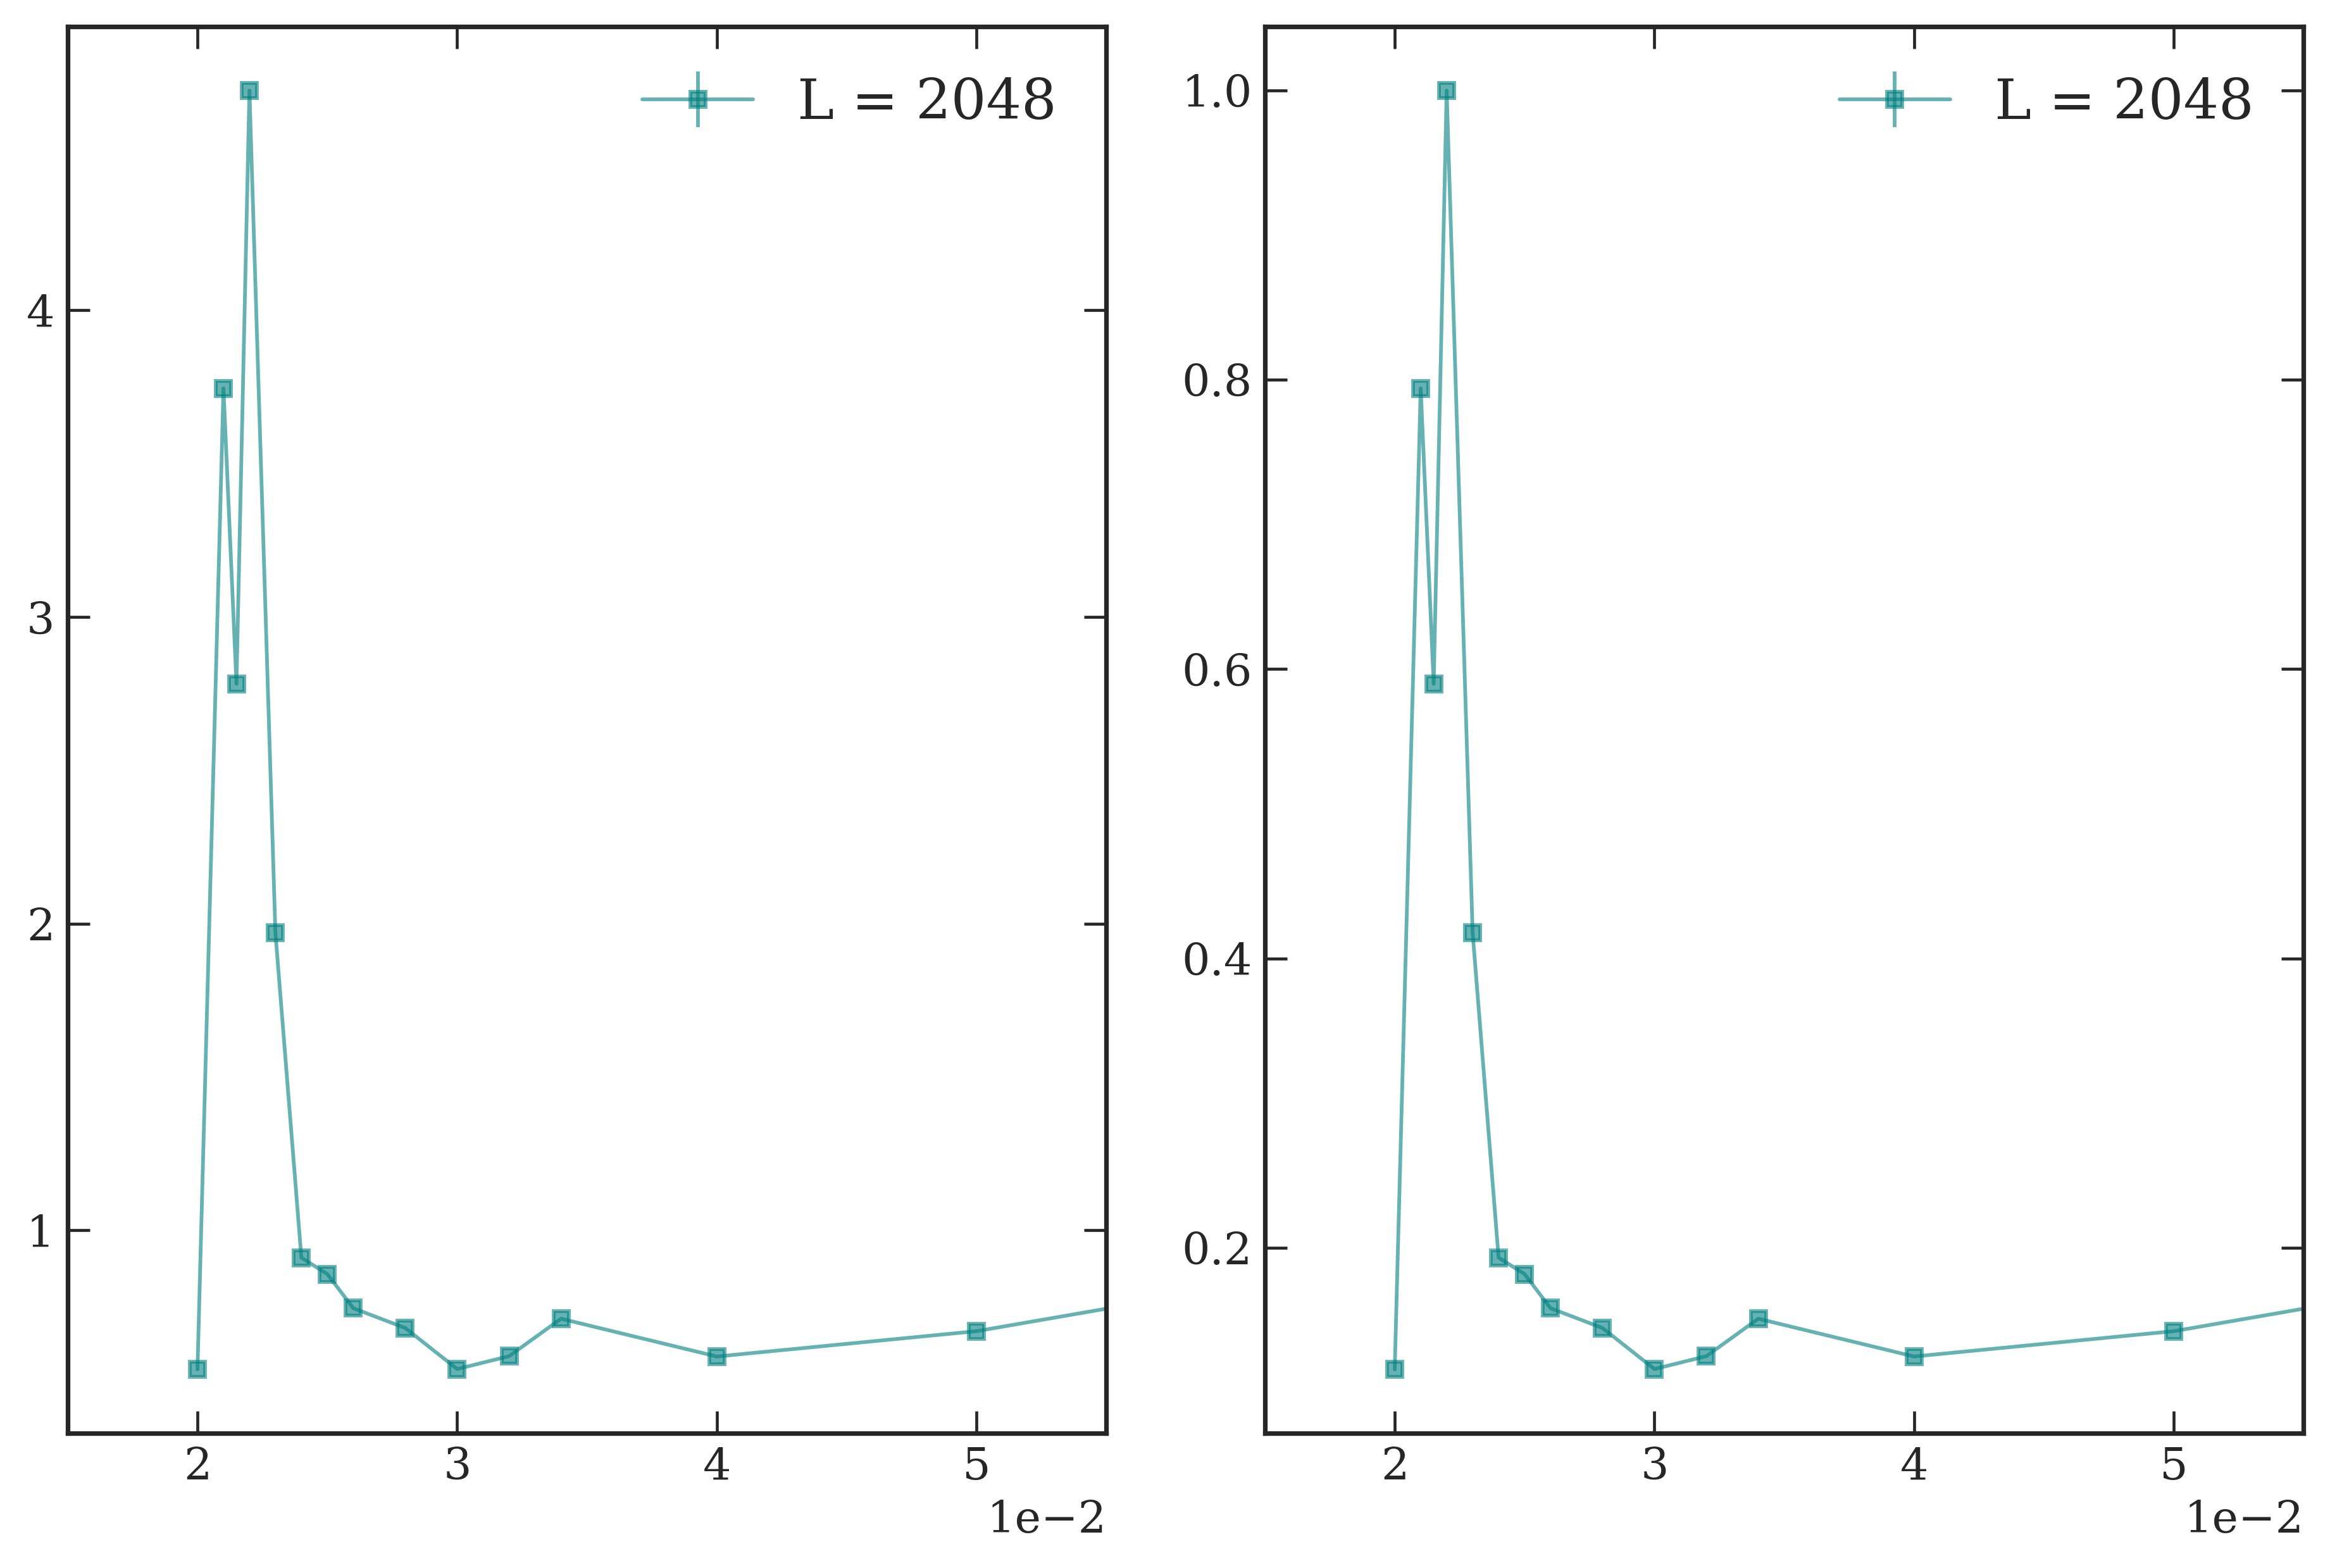

In [111]:
fig, ax = plt.subplots(ncols=2)
marker_shape = ['s', 'o', '^', 'v', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']


for N, act_list in enumerate(ada.act_list):

    binder, sus = ada.get_binder_susceptibility(ada.LX[N])
    av_def = ada.get_av_defects(ada.LX[N], density=False)[1]

    act_max = 0.022
    act_max_idx = act_list.index(act_max)

    ax[0].errorbar(act_list, sus[:,0] , sus[:,1], marker = f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = f'L = {ada.LX[N]}')
   # ax[0].errorbar(act_list, sus[:,0]/np.sqrt(av_def[:,0])**2, sus[:,1], marker = f'{marker_shape[N]}',\
   #                 color = f'C{N}', alpha=.6, lw=1, markersize=4, label = f'L = {ada.LX[N]}')
    #   ax[3].plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
    ax[1].errorbar(act_list, sus[:,0] / sus[act_max_idx,0].max(), sus[:,1] / sus[act_max_idx,0].max(), marker = f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = f'L = {ada.LX[N]}')

    ax[0].set_xlim([0.015, 0.055])
    ax[1].set_xlim([0.015, 0.055])
    ax[0].legend()  
    ax[1].legend()

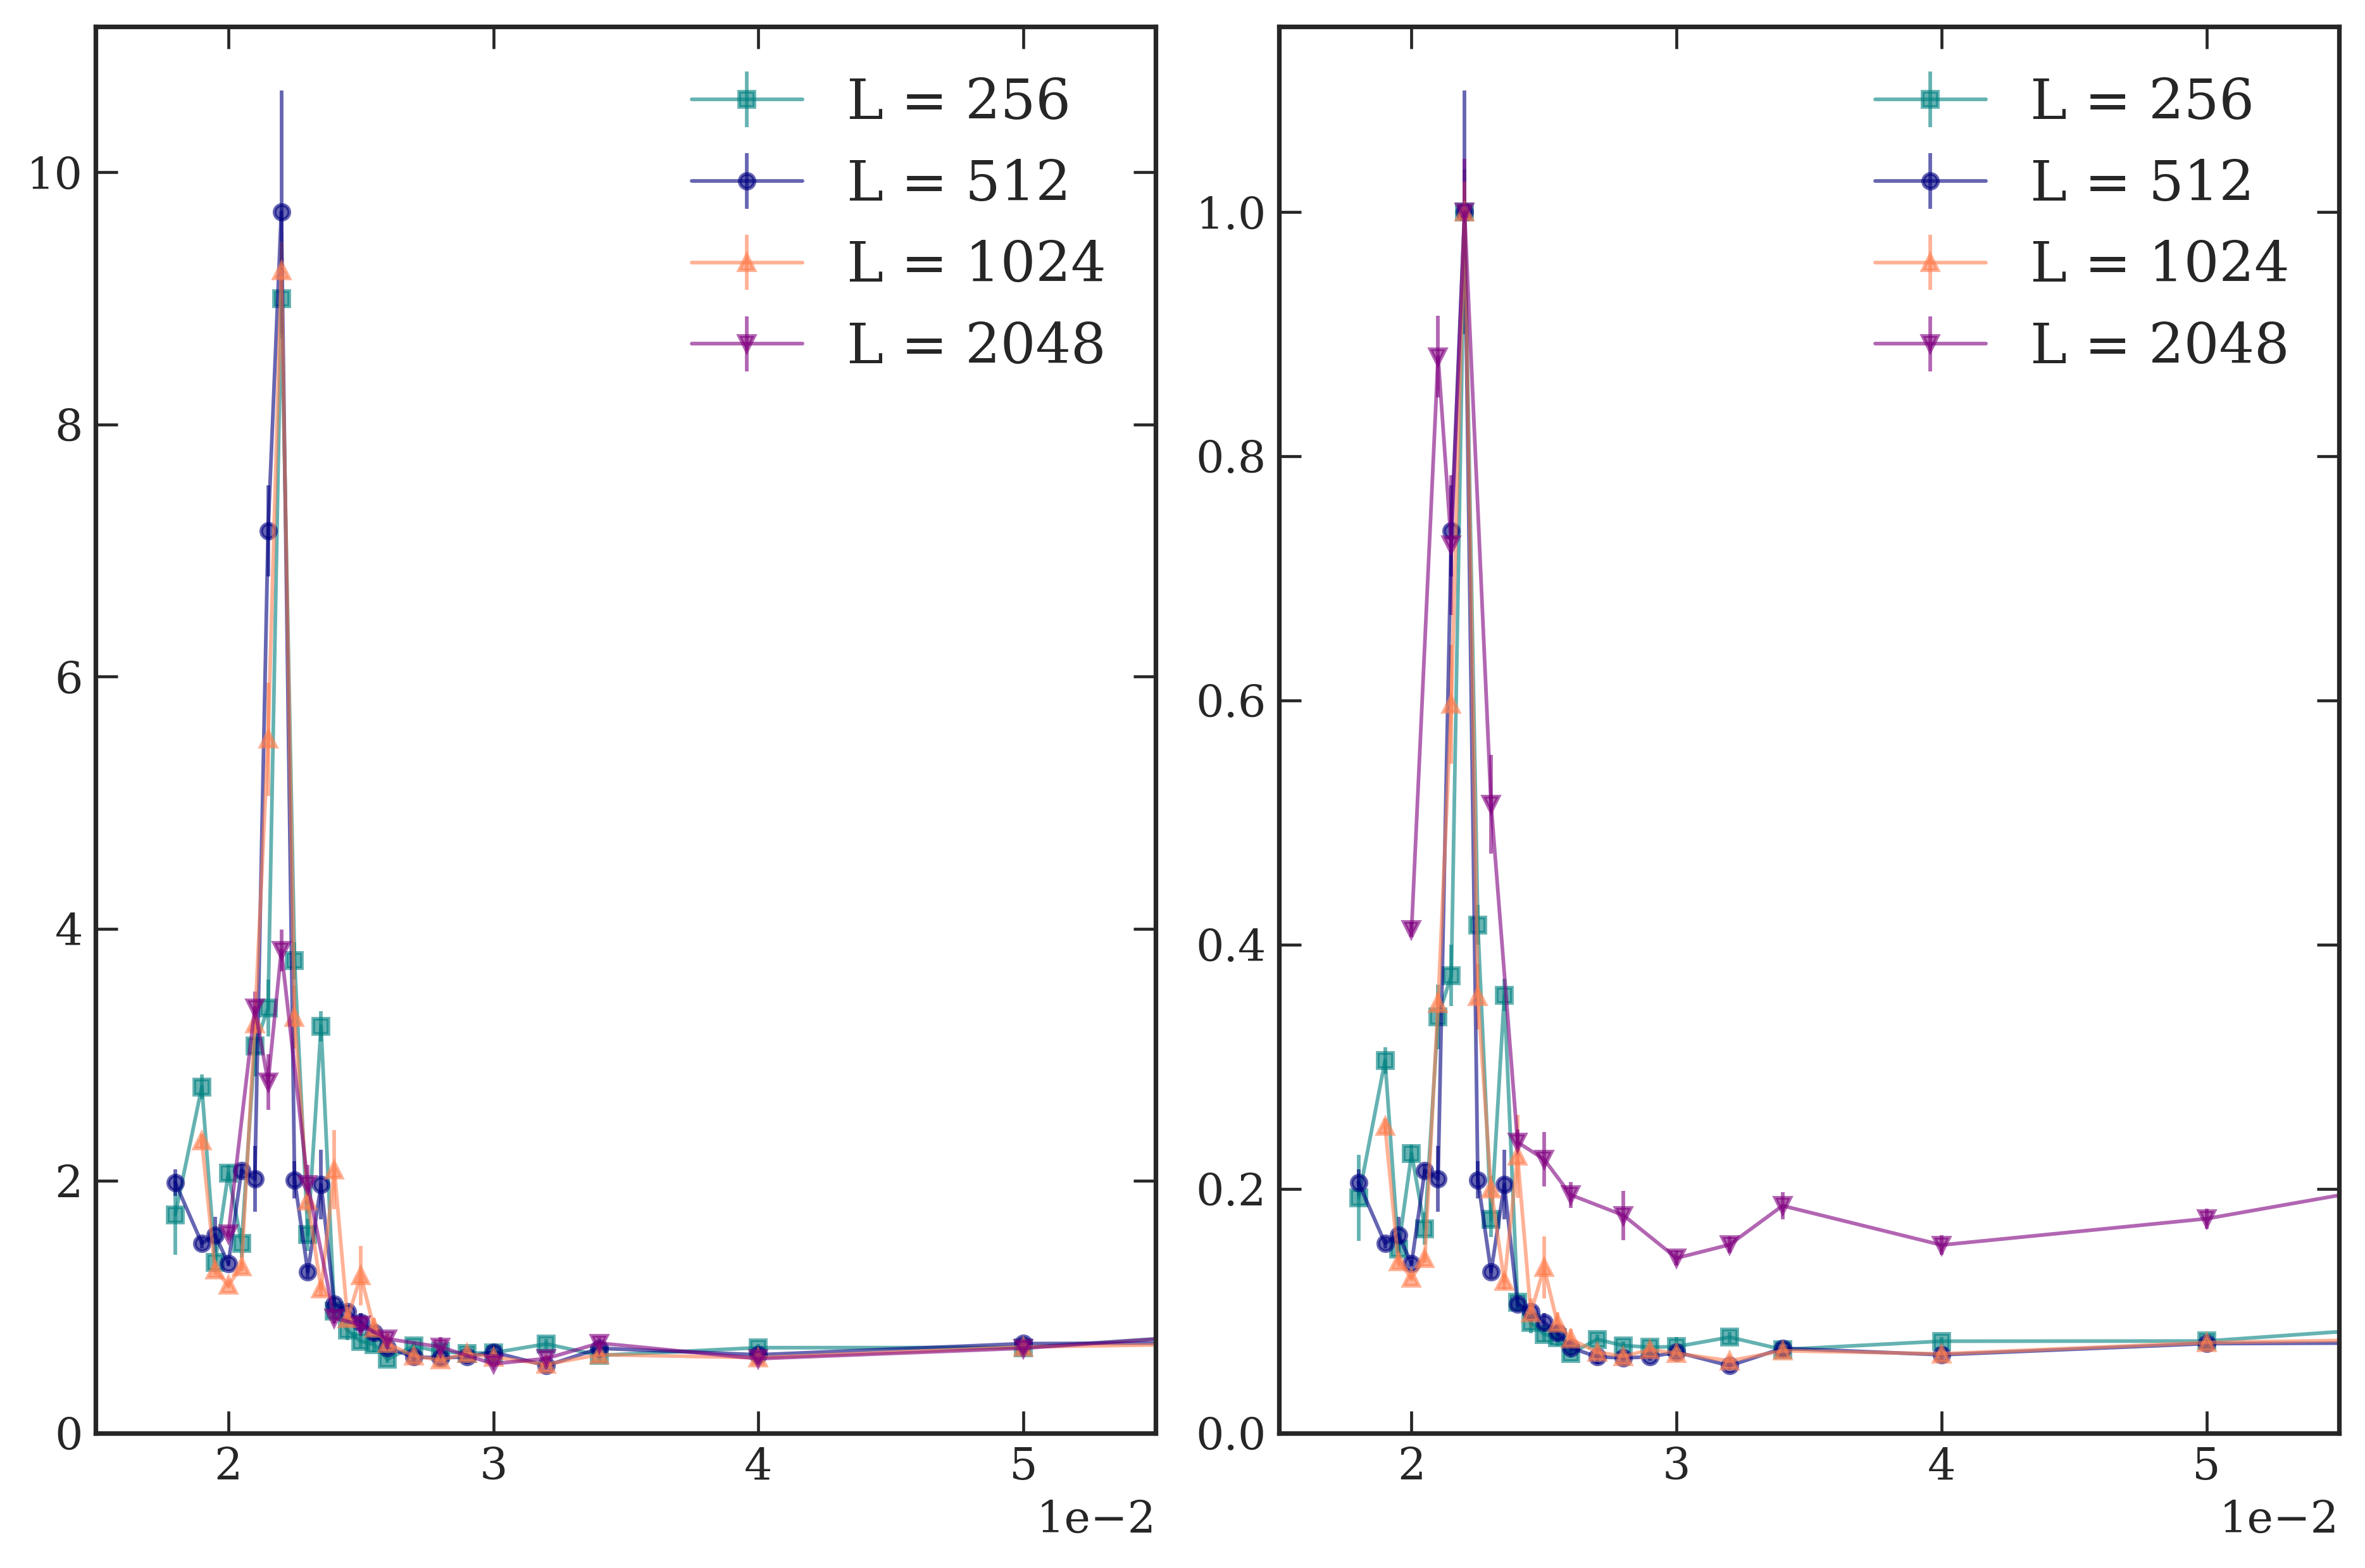

In [80]:
fig, ax = plt.subplots(ncols=2)
marker_shape = ['s', 'o', '^', 'v', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']


for N, act_list in enumerate(ada.act_list):

    binder, sus = ada.get_binder_susceptibility(ada.LX[N])
    av_def = ada.get_av_defects(ada.LX[N])[1]

    act_max = 0.022
    act_max_idx = act_list.index(act_max)

    ax[0].errorbar(act_list, sus[:,0], sus[:,1], marker = f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = f'L = {ada.LX[N]}')
    #   ax[3].plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
    ax[1].errorbar(act_list, sus[:,0] / sus[act_max_idx,0].max(), sus[:,1] / sus[act_max_idx,0].max(), marker = f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4, label = f'L = {ada.LX[N]}')

    ax[0].set_xlim([0.015, 0.055])
    ax[1].set_xlim([0.015, 0.055])
    ax[0].legend()  
    ax[1].legend()

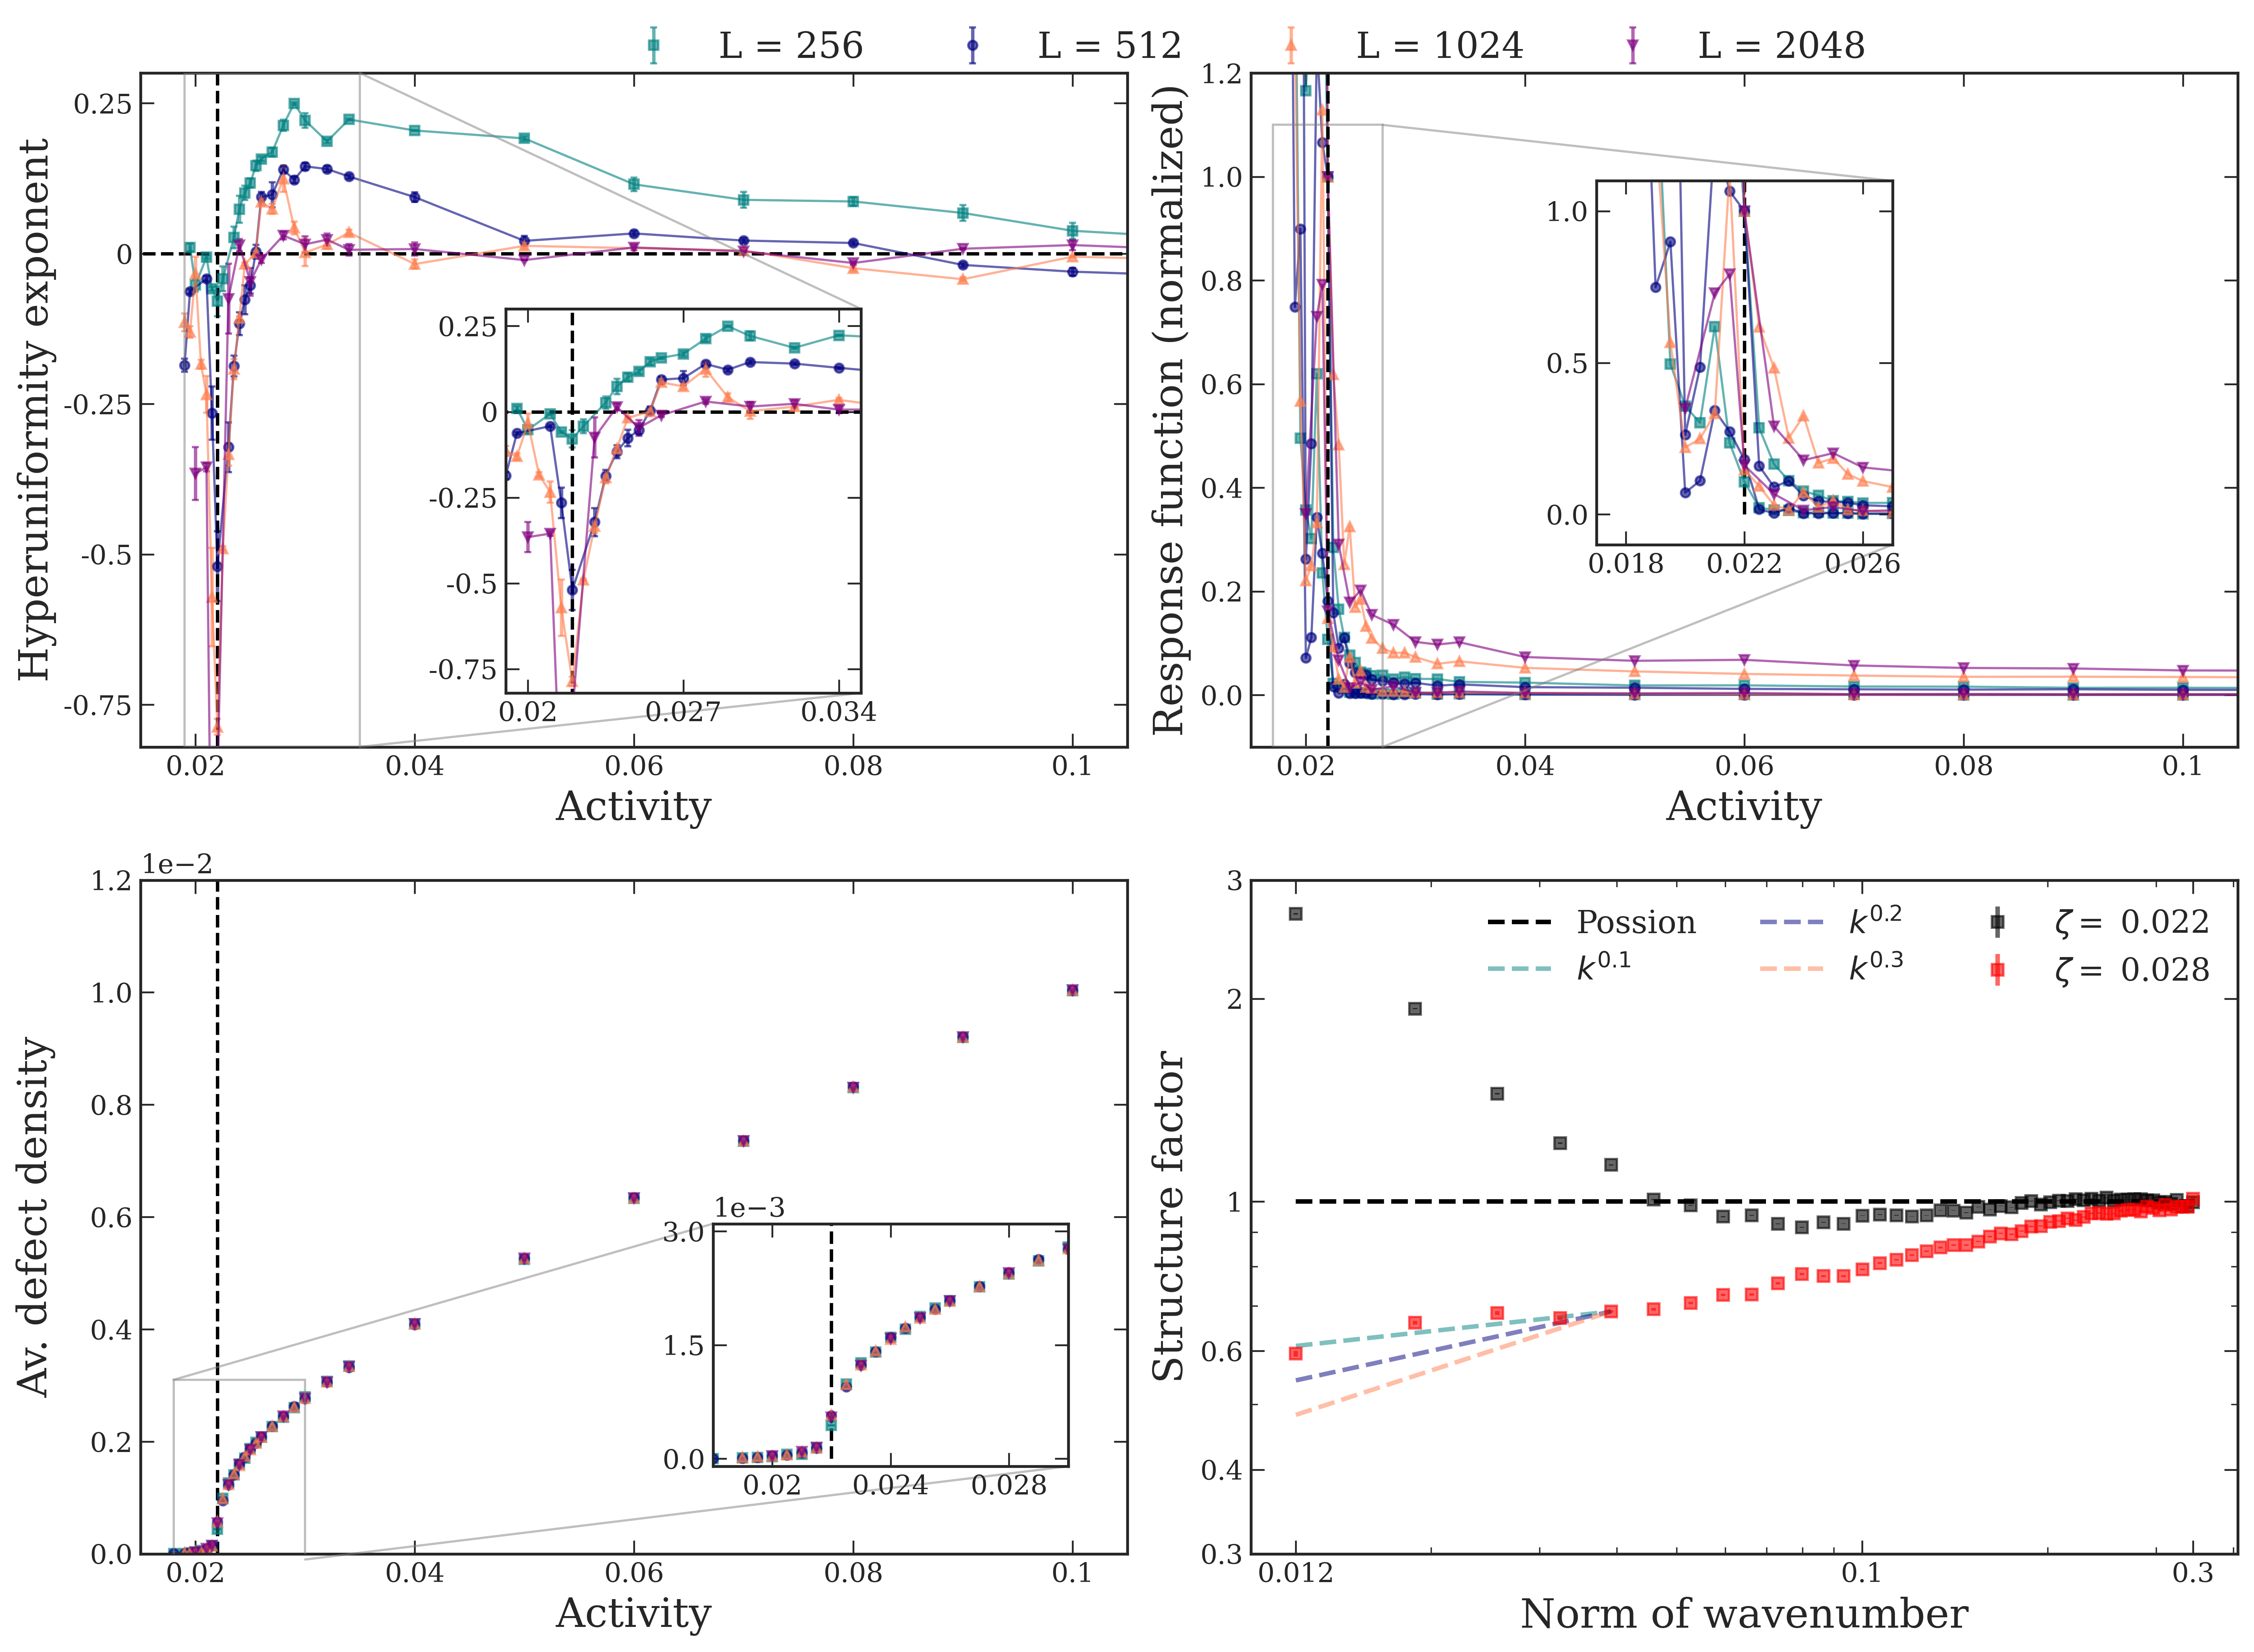

In [7]:

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 10)) 
ax = ax.flatten()

peak1 = 0.022
peak2 = 0.028

xmin = 0.37
ymin = 0.08
width = 0.3
ax1, axin1 = ada.plot_alpha_mean_single(use_density_fit = True, plot_sfac=True, weighted=False, breakax = False, ax = ax[0], inset_box = [xmin, ymin,1.2*width,1.9*width])
ax2, axin2  = ada.plot_av_defects(act_bounds=[0.021, 0.024], ax=ax[2], inset_box = [0.58, 0.13, 1.2*width, 1.2*width])# inset_box = [0.28, 0.7, 0.25, 0.3])# inset_box = [0.6, 0.1, width, width], ax = ax[2])


axin1_xlims = [0.019, 0.035]
axin1_ylims = [-.82, 0.3]
ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.82, 0.3]

axin2_xlims = [0.018, 0.03]
axin2_ylims = [-0.0001, 0.0031]

yticks = [-.75, -.5, -.25, 0, 0.25, 0.5]
axin1_yticks =  [-.75, -.5, -.25, 0, 0.25,]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
#axin1_yticks = np.round(np.linspace(axin1_ylims[0]+.1, axin1_ylims[1] -.1,3), 3)

axin2_xticks = np.round(np.linspace(axin2_xlims[0]+0.002, axin2_xlims[1] - 0.002,3), 3)
axin2_yticks = np.round(np.linspace(axin2_ylims[0]+.0001, axin2_ylims[1] -.0001,3), 4)

ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
ax1.indicate_inset_zoom(axin1,)

axin2.set(xticks=axin2_xticks, yticks=axin2_yticks, xlim=axin2_xlims, ylim=axin2_ylims, xticklabels=axin2_xticks) #, yticklabels=axin2_yticks, )
ax2.set(xticks=xticks, xticklabels=xticks,xlim=ax1_xlims, ylim=[0, 0.012])


ax2.vlines(peak1, 0, 0.02, color = 'k', lw=1.5,linestyle = '--')
#ax2.vlines(peak2, 0, 0.02, color = 'r', lw=1.5, linestyle = '--')
#axin2.vlines(peak2, 0, 0.01, color = 'r', lw=1.5, linestyle = '--')
axin2.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')
ax2.indicate_inset_zoom(axin2)

ax1.set_ylabel(r'Hyperuniformity exponent', labelpad=3)
ax2.set_ylabel(r'Av. defect density', labelpad=15)
#fig.legend(ncol=4)

#ax1.axvspan(0.026, 0.030, alpha=0.2)


normalize_sus = True
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

axinn = ax[1].inset_axes([0.35, 0.3,width,1.8*width])


axinn_xlims = [0.017, 0.027]
axinn_ylims = [-.1, 1.1]
axinn_xticks = np.round(np.linspace(axinn_xlims[0]+0.001, axinn_xlims[1] - 0.001,3), 3)
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3), 3)
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax[1].indicate_inset_zoom(axinn)  
axinn.vlines(peak1, 0, 1.2, color = 'k', lw=1.5, linestyle = '--')

fig.legend(ncol=8, fontsize = 16, bbox_to_anchor=(0.84, 1.025))

ax3 = ada.plot_sfac_per_activity(LX = 1024, weighted=False, act_list=[0.022,0.028,], ax = ax[3])

if 0:
  axin3 = ax[3].inset_axes([0.35, 0.15,width,1.8*width])
  axin3_xlims = [0.017, 0.027]
  axin3_ylims = [-.1, .8]
  axin3_xticks = np.round(np.linspace(axin3_xlims[0]+0.001, axin3_xlims[1] - 0.001,3), 3)
  axin3_yticks = np.round(np.linspace(axin3_ylims[0]+.1, axin3_ylims[1] -.1,3), 3)
  axin3.set(xticks=axin3_xticks, yticks=axin3_yticks, xticklabels=axin3_xticks, yticklabels=axin3_yticks, xlim=axin3_xlims, ylim=axin3_ylims)
  ax[3].indicate_inset_zoom(axin3)
  axin3.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')


for N, act_list in enumerate(ada.act_list):

        binder, sus = ada.get_binder_susceptibility(ada.LX[N])

        act_max = 0.022
        act_max_idx = act_list.index(act_max)

      #  ax[1].plot([ada.LX[N]], sus[act_max_idx], label = f'act = {act_list[act_max_idx]}', marker = 'o', color = f'C{N}')
        if normalize_sus:    
            sus = sus / sus[act_max_idx].max()
            

        reduced_act = (np.array(act_list) - act_max) / act_max
        reduced_act *= system_size_list[N] ** 2

        ax[1].plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
     #   ax[3].plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
        axinn.plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
      #  axin3.plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)


ax[1].set_ylim(-.1,1.2)

ax3_xlims = [0.001, 0.3]
ax3_ylims = [0.3, 2.1]
ax3_xticks = np.round(np.linspace(axinn_xlims[0]+0.001, axinn_xlims[1] - 0.001,3), 3)
ax3_yticks = [0.3, 0.4, 0.6, 1, 2, 3]

ax[3].set_ylim(.3, 3)
ax[3].set(yticks=ax3_yticks,yticklabels=ax3_yticks,)
ax3_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3), 3)
ax[1].set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
#ax[3].set(xticks=ax3_xticks,xticklabels=ax3_xticks, yticks=ax3_yticks, yticklabels=ax3_yticks, xlim=ax3_xlims, ylim=ax3_ylims)
#from matplotlib.ticker import ScalarFormatter
#ax3.get_xaxis().set_major_formatter(ScalarFormatter())
#ax3.get_yaxis().set_major_formatter(ScalarFormatter())
#ax[3].text(0.1, 0.5, rf'Possibly the "order parameter" or binder cumulants v activity', transform=ax[3].transAxes, fontsize=12, verticalalignment='top')

ax1.set_xlabel(r'Activity')
ax[2].set_xlabel(r'Activity')
ax[1].set_xlabel('Activity')
ax[1].set_ylabel('Response function (normalized)')

#ax[3].set_xlabel('Activity')
#ax[3].set_ylabel('Binder Cumulant')

ax[1].vlines(peak1, -1, 1.5, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax[3].vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

ax3.legend(loc = 'upper right', fontsize=14, ncol=3)
#fig.supxlabel(r'Activity')
fig.tight_layout()
fig.dpi = 420
fig.savefig('data/hyperuniformity.png', dpi = 420, pad_inches = .5)

#axin1.vlines(peak2, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(9, 6))
axx = ada.plot_sfac_per_activity(LX = 1024, act_list=[0.022,0.028,], ax = ax[0])#act_list = [0.022, 0.024, 0.026, 0.027], weighted = True)

ax.set_ylim([0.3, 1.3])
ax.legend(loc='lower right', ncol=3)

In [ ]:
fig, ax = ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.1], include_fluc=False, include_sfac=True, include_unweighted=True, use_time_av = False);
ax.set_ylim(-1, .5)
ax.set_xlim(0.016, .05)
ax.legend()
ax.vlines(0.028,-1,.5, color='b', lw=1, linestyle='--', label=r'$\zeta_c$')
ax.vlines(0.022,-1,.5, color='b', lw=1, linestyle='--', label=r'$\zeta_c$')
ax.hlines(0,0.016,0.05, color='k', lw=1, linestyle='--')

In [ ]:
fig, ax = ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.1], include_fluc=False, include_sfac=True, include_unweighted=True, use_time_av = True);
ax.set_ylim(-1, .5)
ax.set_xlim(0.016, .05)
ax.legend()
ax.vlines(0.028,-1,.5, color='b', lw=1, linestyle='--', label=r'$\zeta_c$')
ax.vlines(0.022,-1,.5, color='b', lw=1, linestyle='--', label=r'$\zeta_c$')
ax.hlines(0,0.016,0.05, color='k', lw=1, linestyle='--')

In [4]:
binder256, sus256 = ada.get_binder_susceptibility(LX = 256)
binder512, sus512 = ada.get_binder_susceptibility(LX = 512)
binder1024, sus1024 = ada.get_binder_susceptibility(LX = 1024)
binder2048, sus2048 = ada.get_binder_susceptibility(LX = 2048)
act_list = list(np.load(os.path.join(ada.inputs_paths[0], "activity_list.npy")))[5:10]

In [ ]:

sus215 = []
sus22 = []
act_crit = [0.020, 0.021, 0.0215, 0.022, 0.0225, 0.023]
sus_arr = np.zeros((len(act_crit), len(ada.LX)))
for i, LX in enumerate(ada.LX):
    binder, sus = ada.get_binder_susceptibility(LX = LX)
    act_list = list(np.load(os.path.join(ada.inputs_paths[i], "activity_list.npy")))

    sus = np.nanmean(sus, axis = 1)

    for j, act in enumerate(act_crit):
        try:
            sus_arr[j, i] = sus[act_list.index(act),0]
        except:
            sus_arr[j, i] = np.nan


fig, ax = plt.subplots(figsize=(9, 6))

for i, act in enumerate(act_crit):
    ax.plot(ada.LX, sus_arr[i, :], 'o-', label = rf'$\zeta = {act}$')

ax.legend(ncol=3, fontsize=10)
ax.set_xlabel('System size')
ax.set_ylabel(r'$\chi$')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xticks(ada.LX, ada.LX)

In [ ]:
act_bounds = [0.019, 0.04]
act_bounds_list = [act_bounds] * len(system_size_list)
fig, ax = ada.plot_binder_cumulants(act_bounds_list=act_bounds_list, LX_list=[256,512,1024, 2048],\
                           normalize = False, plot_binder=True, save = False);
ax.set_ylim(0.2, .7)
ax.set_xlim(0.018, 0.03)

In [ ]:
window_idx_bounds_list = [[7, None], [0, None], [0, None],  [0, None]]
act_max_list = [0.022, 0.0215, 0.0215, 0.022]    
fig, ax = ada.plot_susceptibility(act_bounds = [0.015, .1], \
            window_idx_bounds_list = window_idx_bounds_list, act_max_list=act_max_list, save = True)
ax.set_ylim(0, 1.1)
ax.set_xlim(0.015, .06)
fig.savefig(os.path.join(ada.output_path, 'susceptibility_zoom.png'), dpi = 420, pad_inches=0.25)

In [ ]:
fig, ax = ada.plot_alpha_mean_all(use_density_fit=True, act_bounds = [0.02, 0.1], );
for i, axx in enumerate(ax):
    if i == 1:
        axx.set_ylim(-.65, .5)
        
    elif i == 0:
        axx.set_ylim(-.6, .3)
    else:
        axx.set_ylim(-.6, .3)
    label1 = r'$\zeta$ = 0.022' if i == 0 else None
    label2 = r'$\zeta$ = 0.028' if i == 0 else None
    axx.vlines(0.022, -.65, .5, color = 'red', linewidth = 1, linestyle = '--', label = label1)
    axx.vlines(0.028, -.65, .5, color = 'blue', linewidth = 1, linestyle = '--', label = label2)
    axx.set_xlim(0.015, .105)
    axx.hlines(0, 0, .105, color = 'black', linewidth = 1, linestyle = '--')
fig.legend(ncol=8, fontsize = 14, bbox_to_anchor=(0.88, .995))
#ax.set_ylim(-.6, .5)
#ax.set_xlim(0.015, .1)

In [ ]:
fig, ax = ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.1], include_fluc=False, include_sfac=True, include_unweighted=True
                               );
ax.set_ylim(-.6, .5)
ax.set_xlim(0.015, .1)

In [30]:
def log_func(x, a, b, c):
    return a * np.log(np.abs(x * b)) + c
def linear(x, a, b):
    return a * x ** 0.5 + b

def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density



fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y = a \ln (x / b) + c $'
fit_string_lin = rf'$y = a x + b$'
fit_string_power = rf'$y = a x^b + c$'
param_guess_log = np.array([0.005, 500,0.001])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.5,-0.005])
param_guess_logistic = np.array([0.002, 2000, 0.023,])

fit_func = linear
param_guess = param_guess_lin
fit_string = fit_string_lin

fit_func = logistic_func
param_guess = param_guess_logistic
fit_string = fit_string_logistic

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power

fit_func = log_func
param_guess = param_guess_log
fit_string = fit_string_log

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 14, param_guess = param_guess)


In [32]:
ada.act_list[2][10]

0.024

In [ ]:
fig, ax, axin = ada.plot_av_defects(act_bounds=[0.021, 0.024], inset_box = [0.32, 0.66, 0.25, 0.3])


axin.set_xlim([0.018,0.03])
axin.set_ylim([0.000001, 0.003])
axin.set_xticks([0.02,0.025,0.03], [0.02,0.025,0.03], fontsize=10)
axin.set_yticks([0.001,0.002,0.003], [0.001,0.002,0.003], fontsize=10)

ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
ax.vlines(0.022, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
#ax.vlines(0.02, 0, 0.01, color = 'k', linestyle = '--')
axin.vlines(0.022, 0, 0.01, color = 'k', lw=1, linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)


#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend(ncol=2, loc='lower right')

ax.indicate_inset_zoom(axin)

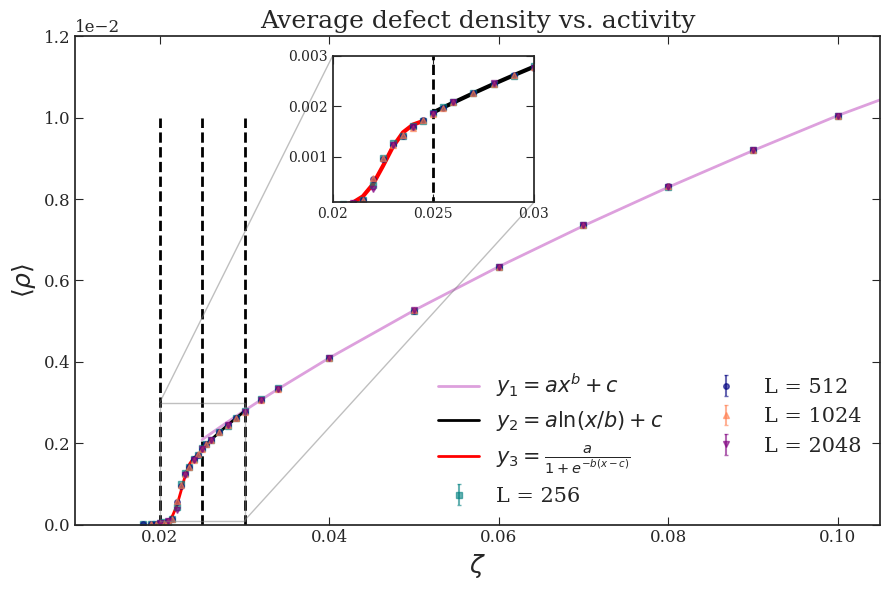

In [35]:

fig, ax, axin = ada.plot_av_defects(act_bounds=[0.021, 0.024], inset_box = [0.32, 0.66, 0.25, 0.3])

p_power = np.array([0.05563591932395208, 0.5925762989386102, -0.004164450175068781])
p_log = np.array([0.004958101922293866, 55.446575064673716, 0.00026152453890848973])
p_logistic = np.array([0.001622290610085664, 2324.4665041694207, 0.022408143634890017])
p_logistic = np.array([0.0017626217917815334, 1822.8633695130754, 0.02257778086582252])

#axin = ax.inset_axes([0.3, 0.64, 0.2, 0.25])
axin.set_xlim([0.02,0.03])
axin.set_ylim([0.0001, 0.003])
axin.set_xticks([0.02,0.025,0.03], [0.02,0.025,0.03], fontsize=10)
axin.set_yticks([0.001,0.002,0.003], [0.001,0.002,0.003], fontsize=10)

ax.indicate_inset_zoom(axin)

act_list = ada.act_list[0]
act_list_power = act_list[act_list.index(0.025):]
act_list_log = np.array(act_list[act_list.index(0.025):act_list.index(0.032)])
act_list_logistic = np.array(act_list[act_list.index(0.02):act_list.index(0.025)])


fit_string_logistic = r'$y_3 = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y_2 = a \ln (x / b) + c $'
fit_string_power = rf'$y_1 = a x^b + c$'

ax.plot(act_list_power, power(act_list_power, *p_power), '-', label = fit_string_power, color=f'C5')
ax.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6')
ax.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7')


axin.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6', lw=3)
axin.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7', lw=3)

ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
ax.vlines(0.03, 0, 0.01, color = 'k', linestyle = '--')
ax.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
ax.vlines(0.02, 0, 0.01, color = 'k', linestyle = '--')
axin.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)


#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend(ncol=2, loc='lower right')

In [ ]:


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 6, param_guess = param_guess)

fig, ax = ada.plot_av_defects(fit_dict=fit_dict,act_bounds=[0.025, 0.03], LX_list=[256,512,1024])
ax.set_xlim([0.01,0.1])
ax.vlines(0.03, 0, 0.005, color = 'k', linestyle = '--')
ax.vlines(0.025, 0, 0.005, color = 'k', linestyle = '--')
ax.set_ylim([0, .01])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend() #loc='lower right')

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(14, 10)) 
ax = ax.flatten()

peak1 = 0.022
peak2 = 0.028

xmin = 0.37
ymin = 0.08
width = 0.3
ax1, axin1 = ada.plot_alpha_mean_single(use_density_fit = True, plot_sfac=True, breakax = False, ax = ax[0], inset_box = [xmin, ymin,width,1.8*width])
ax2, axin2  = ada.plot_av_defects(act_bounds=[0.021, 0.024], ax=ax[2], inset_box = [0.58, 0.13, 1.2*width, 1.2*width])# inset_box = [0.28, 0.7, 0.25, 0.3])# inset_box = [0.6, 0.1, width, width], ax = ax[2])


axin1_xlims = [0.019, 0.025]
axin1_ylims = [-.6, 0.1]
ax1_xlims = [0.015, 0.105]
ax1_ylims = [-.6, 0.55]

axin2_xlims = [0.018, 0.03]
axin2_ylims = [-0.0001, 0.0031]

yticks = [-.5, -.25, 0, 0.25, 0.5]
xticks = np.round(np.linspace(ax1_xlims[0], ax1_xlims[1], 5), 2)
axin1_xticks = np.round(np.linspace(axin1_xlims[0]+0.001, axin1_xlims[1] - 0.001,3), 3)
axin1_yticks = np.round(np.linspace(axin1_ylims[0]+.1, axin1_ylims[1] -.1,3), 3)

axin2_xticks = np.round(np.linspace(axin2_xlims[0]+0.002, axin2_xlims[1] - 0.002,3), 3)
axin2_yticks = np.round(np.linspace(axin2_ylims[0]+.0001, axin2_ylims[1] -.0001,3), 4)

ax1.set(xticks=xticks, yticks=yticks, xticklabels=xticks, yticklabels=yticks, xlim=ax1_xlims, ylim=ax1_ylims)
axin1.set(xticks=axin1_xticks, yticks=axin1_yticks, xticklabels=axin1_xticks, yticklabels=axin1_yticks, xlim=axin1_xlims, ylim=axin1_ylims)

ax1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
axin1.vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
#ax1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
#axin1.vlines(peak2, -1, 1, color = 'r', lw = 1.5, linestyle = '--', alpha = 1)
ax1.hlines(0, 0, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)

ax1.indicate_inset_zoom(axin1,)

axin2.set(xticks=axin2_xticks, yticks=axin2_yticks, xlim=axin2_xlims, ylim=axin2_ylims, xticklabels=axin2_xticks) #, yticklabels=axin2_yticks, )
ax2.set(xticks=xticks, xticklabels=xticks,xlim=ax1_xlims, ylim=[0, 0.012])


ax2.vlines(peak1, 0, 0.02, color = 'k', lw=1.5,linestyle = '--')
#ax2.vlines(peak2, 0, 0.02, color = 'r', lw=1.5, linestyle = '--')
#axin2.vlines(peak2, 0, 0.01, color = 'r', lw=1.5, linestyle = '--')
axin2.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')
ax2.indicate_inset_zoom(axin2)

ax1.set_ylabel(r'Hyperuniformity exponent', labelpad=3)
ax2.set_ylabel(r'Av. defect density', labelpad=15)
#fig.legend(ncol=4)

#ax1.axvspan(0.026, 0.030, alpha=0.2)


normalize_sus = True
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

axinn = ax[1].inset_axes([0.35, 0.3,width,1.8*width])


axinn_xlims = [0.017, 0.027]
axinn_ylims = [-.1, 1.1]
axinn_xticks = np.round(np.linspace(axinn_xlims[0]+0.001, axinn_xlims[1] - 0.001,3), 3)
axinn_yticks = np.round(np.linspace(axinn_ylims[0]+.1, axinn_ylims[1] -.1,3), 3)
axinn.set(xticks=axinn_xticks, yticks=axinn_yticks, xticklabels=axinn_xticks, yticklabels=axinn_yticks, xlim=axinn_xlims, ylim=axinn_ylims)
ax[1].indicate_inset_zoom(axinn)  
axinn.vlines(peak1, 0, 1.2, color = 'k', lw=1.5, linestyle = '--')

if 0:
  axin3 = ax[3].inset_axes([0.35, 0.15,width,1.8*width])
  axin3_xlims = [0.017, 0.027]
  axin3_ylims = [-.1, .8]
  axin3_xticks = np.round(np.linspace(axin3_xlims[0]+0.001, axin3_xlims[1] - 0.001,3), 3)
  axin3_yticks = np.round(np.linspace(axin3_ylims[0]+.1, axin3_ylims[1] -.1,3), 3)
  axin3.set(xticks=axin3_xticks, yticks=axin3_yticks, xticklabels=axin3_xticks, yticklabels=axin3_yticks, xlim=axin3_xlims, ylim=axin3_ylims)
  ax[3].indicate_inset_zoom(axin3)
  axin3.vlines(peak1, 0, 0.01, color = 'k', lw=1.5, linestyle = '--')


for N, act_list in enumerate(ada.act_list):

        binder, sus = ada.get_binder_susceptibility(ada.LX[N])

        act_max = 0.022
        act_max_idx = act_list.index(act_max)

      #  ax[1].plot([ada.LX[N]], sus[act_max_idx], label = f'act = {act_list[act_max_idx]}', marker = 'o', color = f'C{N}')
        if normalize_sus:    
            sus = sus / sus[act_max_idx].max()
            

        reduced_act = (np.array(act_list) - act_max) / act_max
        reduced_act *= system_size_list[N] ** 2

        ax[1].plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
     #   ax[3].plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
        axinn.plot(act_list, sus, f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)
      #  axin3.plot(act_list, binder,  f'{marker_shape[N]}', color = f'C{N}', alpha=.6, lw=1, markersize=4)


ax[1].set_ylim(-.1,1.2)

ax[1].set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
ax[3].set(xticks=xticks,xticklabels=xticks, xlim=ax1_xlims,)
ax[3].text(0.1, 0.5, rf'Possibly the "order parameter" or binder cumulants v activity', transform=ax[3].transAxes, fontsize=12, verticalalignment='top')

#ax[1].set_xlabel('Activity')
ax[1].set_ylabel('Susceptibility (normalized)')

#ax[3].set_xlabel('Activity')
#ax[3].set_ylabel('Binder Cumulant')
ax[3].set_ylim(-.1, .8)
ax[1].vlines(peak1, -1, 1.5, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)
ax[3].vlines(peak1, -1, 1, color = 'k', lw = 1.5, linestyle = '--', alpha = 1)


fig.legend(ncol=8, fontsize = 14, bbox_to_anchor=(0.75, 1.025))
fig.supxlabel(r'Activity')
fig.tight_layout()
fig.dpi = 420